# 04: Adding dissipation to the Jaynes-Cummings model

In this tutorial we will add interactions with the environment to the Jaynes-Cummings model in the form of dissipation from the atom and the cavity. We will use the Wigner function to visualise the modes of the cavity certain times in the evolution to see how these evolve over time.

## Tasks

- [Construct collapse operators](#construct-collapse-operators)
- [Solve the Lindblad Master equation](#solve-the-linblad-master-equation)
- [Visualise cavity modes as Wigner functions](#visualise-cavity-modes-as-wigner-functions)
- [Finding the steady state](#finding-the-steady-state)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import qutip
import numpy as np

## Helper functions

In [3]:
def jcm_h(wc, wa, g, N, atom):
    """ Construct the Jaynes-Cummings Hamiltonian (non-RWA). """
    a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
    sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())
    atom = qutip.tensor(qutip.qeye(N), atom)
    
    H = wc * a.dag() * a + wa * atom + g * (a.dag() + a) * (sm + sm.dag())
    return H

In [4]:
def jcm_rwa_h(wc, wa, g, N, atom):
    """ Construct the Jaynes-Cummings Hamiltonian (RWA). """
    a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
    sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())
    atom = qutip.tensor(qutip.qeye(N), atom)

    H = wc * a.dag() * a + wa * atom + g * (a.dag() * sm + a * sm.dag())
    return H

## Re-cap of solving without dissipation

Let's re-cap what we did in the previous tutorial and solve the Schrödinger equation for the Jaynes-Cummings Hamiltonian without dissipation.

In [5]:
# Jaynes-Cummings parameters
# system parameters
wc = 1.0 * 2 * np.pi  # cavity frequency
wa = 1.0 * 2 * np.pi  # atom frequency
g = 0.05 * 2 * np.pi  # coupling strength
N = 15  # number of cavity fock states

# Atom hamiltonian
H_atom = 0.5 * qutip.sigmaz()

H = jcm_h(wc, wa, g, N, H_atom)

In [6]:
# system operators
a = qutip.tensor(qutip.destroy(N), qutip.qeye(2))
sm = qutip.tensor(qutip.qeye(N), qutip.sigmam())

# relaxation operators
a  # cavity relaxation
a.dag()  # cavity excitation
sm = sm # qubit relaxation

In [7]:
# Operators to determine the expectation values of:
eop_a = a.dag() * a  # light
eop_sm = sm.dag() * sm  # matter

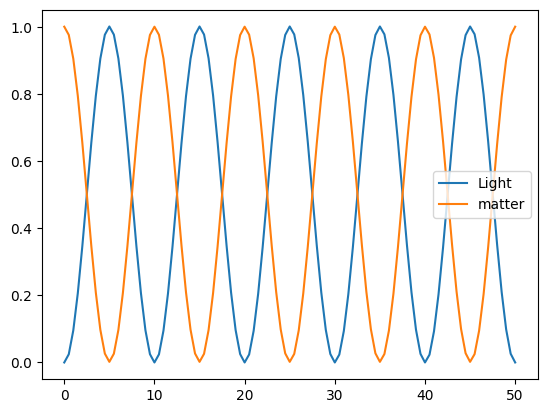

In [8]:
psi0 = qutip.basis([N, 2], [0, 0])  # start with an excited atom
tlist = np.linspace(0, 50, 101)

result = qutip.sesolve(H, psi0, tlist, e_ops=[eop_a, eop_sm])

plt.plot(tlist, result.expect[0], label="Light")
plt.plot(tlist, result.expect[1], label="matter")
plt.legend();

## Construct collapse operators

Now we will create the collapse operators for the Lindblad master equation.

These are also called jump operators or Lindblad operators.

- Define variables for the cavity dissipation rate ($\kappa$), atom dissipation rate ($\gamma$), and average number of thermal bath excitations ($N_{\mathrm{thermal}}$).

- Create a list for adding the collapse operators to.

- Create the cavity relaxation collapse operator. Consider the appropriate operator and then determine the rate based on the dissipation and thermal occupation level.

- Create the cavity excitation collapse operator, again considering the appropriate operator and rate.

- Create the atom relaxation collapse operator, again considering the appropriate operator and rate.

- Add the operators to the list if the corresponding rate is greater than zero.

Some suggested values for the initial dissipation rates and averge bath excitations:

$
  \kappa = 0.005 \\
  \gamma = 0.05 \\
  N_{\mathrm{thermal}} = 5 \\
$

In [9]:
# Dissipation parameters
kappa = 0.005  # cavity dissipation rate
gamma = 0.05  # atom dissipation rate
n_th_a = 5.0  # avg number of thermal bath excitation

In [10]:
c_ops = []

# cavity relaxation
rate = kappa * (1 + n_th_a)
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a)

# cavity excitation, if temperature > 0
rate = kappa * n_th_a
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * a.dag())

# qubit relaxation
rate = gamma
if rate > 0.0:
    c_ops.append(np.sqrt(rate) * sm)

## Solve the Linblad Master equation

- Evolve the system, starting from excited atom state, using mesolve, utilising the collapse operators from above and saving the result.

- Plot the expectation values for the atom and cavity excitations.

- What happens if you extent the evolution time?

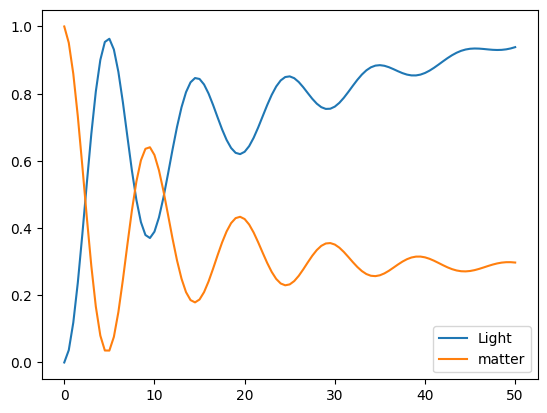

In [11]:
psi0 = qutip.basis([N, 2], [0, 0])  # start with an excited atom
tlist = np.linspace(0, 50, 101)

result = qutip.mesolve(H, psi0, tlist, c_ops, [eop_a, eop_sm])

plt.plot(tlist, result.expect[0], label="Light")
plt.plot(tlist, result.expect[1], label="matter")
plt.legend();

## Visualise cavity modes as Wigner functions

- Note the times when the cavity excitation is at a maximum or minimum.

- Use the master equation solver to generate density matrices of the time evolution (this is the default mode when no expectation operators are given) for these times.

- For each of these density matrices, trace out (partial trace) the atom from the density matrix and create and plot the Wigner function.

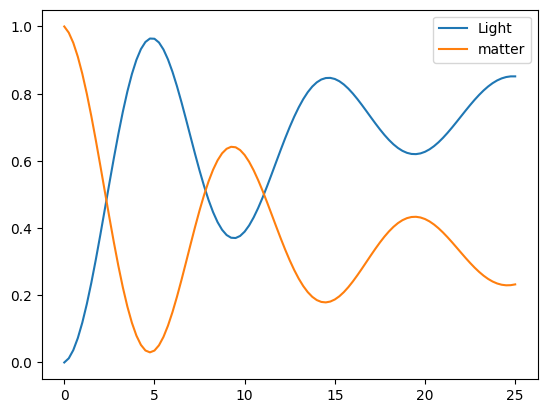

In [12]:
# Find the times of the minima and maxima:

psi0 = qutip.basis([N, 2], [0, 0])  # start with an excited atom
tlist = np.linspace(0, 25, 101)

result = qutip.mesolve(H, psi0, tlist, c_ops, e_ops=[eop_a, eop_sm])

plt.plot(tlist, result.expect[0], label="Light")
plt.plot(tlist, result.expect[1], label="matter")
plt.legend();

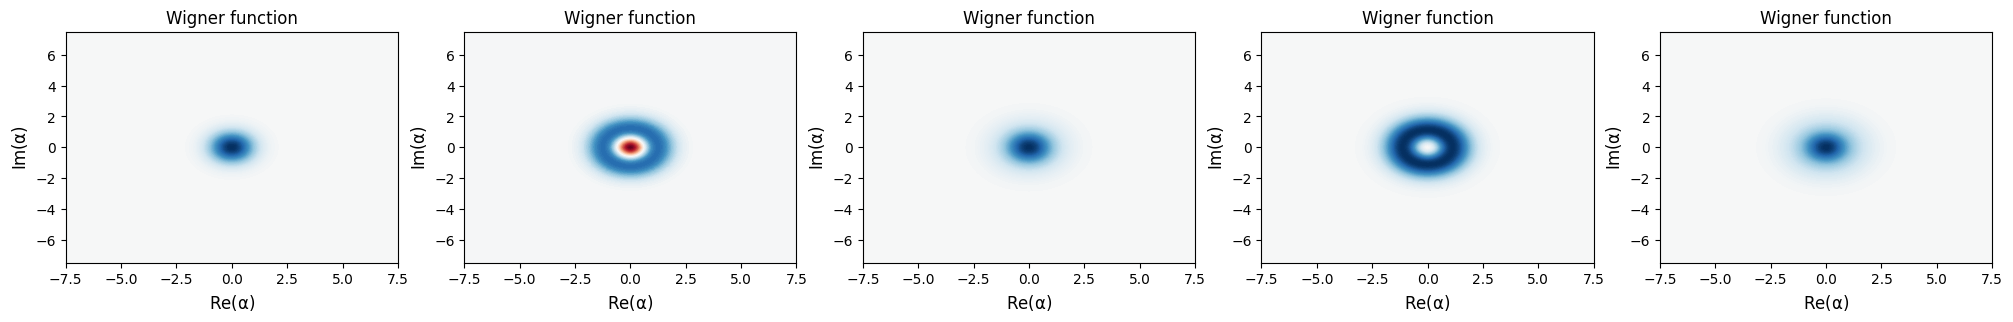

In [13]:
min_max_tlist = [0, 5, 10, 15, 20]
n_plots = len(min_max_tlist)
result = qutip.mesolve(H, psi0, min_max_tlist, c_ops, e_ops=[])

plt.figure(figsize=(6 * n_plots, 3))

for i, (t, rho) in enumerate(zip(tlist, result.states)):
    rho_cavity = qutip.ptrace(rho, 0)
    ax = plt.subplot(1, n_plots + 1, i + 1)
    qutip.visualization.plot_wigner(rho_cavity, ax=ax)

# Finding the steady state

When you extended the time evolution, it looked like the system was heading towards a steady state. Let's find it!

You can use `qutip.steadystate` to determine it. Read the documentation by typing `qutip.steadystate?`.

Plot the expectation values and Wigner function of the steady state and compare them to the values you saw from the evolution.

Cavity expectation: 1.6782957466524462
Matter expectation: 0.314211275570021


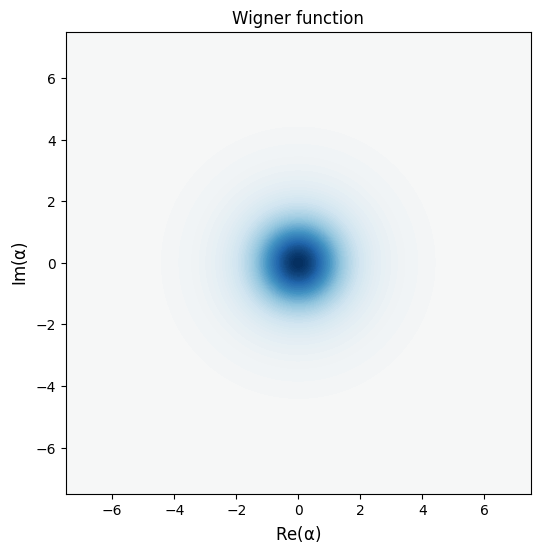

In [14]:
ss_rho = qutip.steadystate(H, c_ops)

print("Cavity expectation:", qutip.expect(eop_a, ss_rho))
print("Matter expectation:", qutip.expect(eop_sm, ss_rho))

rho_cavity = qutip.ptrace(ss_rho, 0)
qutip.visualization.plot_wigner(rho_cavity);

## Links for further study

There is an excellent paper [The Jaynes-Cummings model and its descendants](https://arxiv.org/abs/2202.00330) by Larson and Mavrogordatos, that reviews the Jaynes-Cummings model and its many variations. You can try reading this paper and implementing some of the simpler variants in QuTiP.

If you do, please consider polishing your notebook, adding good explanations to it and submitting it as an example for others by opening a pull request for it at https://github.com/qutip/qutip-tutorials/.

This paper covers a *lot* of work, so don't expect to understand all of it quickly. Start with the earlier sections. We will explore the Jaynes-Cumming model more in the remaining tutorials.